Autoencoder is easy? Nah

In [10]:
import gpustat
gpustat.print_gpustat()
import os
os.environ['CUDA_VISIBLE_DEVICES']='3'
import random
random.seed(0)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, Concatenate, Lambda
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend as K
import seaborn as sns
sns.set(style="white", color_codes=True)
from sklearn.ensemble import GradientBoostingRegressor

import fastai
from fastai.vision import Learner, DataBunch

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data.distributed
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

imperium-sm.hep.caltech.edu  Wed Jul 31 13:31:47 2019  418.67
[0] GeForce GTX 1080 | 38'C,   2 % |   666 /  8119 MB | 3038(655M)
[1] GeForce GTX 1080 | 23'C,   0 % |  8100 /  8119 MB | qnguyen(8089M)
[2] GeForce GTX 1080 | 26'C,   0 % |     1 /  8119 MB |
[3] GeForce GTX 1080 | 22'C,   0 % |    11 /  8119 MB |
[4] GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |
[5] GeForce GTX 1080 | 23'C,   0 % |     1 /  8119 MB |
[6] GeForce GTX 1080 | 24'C,   0 % |     1 /  8119 MB |
[7] GeForce GTX 1080 | 25'C,   0 % |     1 /  8119 MB |


Let's start with a toy dataset that emulate $p_T$, $\eta$, and $\phi$. Starting with $\phi$, which in principle is a flat distribution:

(array([210., 209., 210., 209., 210., 209., 210., 209., 209., 210., 209.,
        210., 209., 210., 209., 209., 210., 209., 210., 209., 210., 209.,
        209., 210., 209., 210., 209., 210., 209., 210.]),
 array([-3.14159265e+00, -2.93215932e+00, -2.72272599e+00, -2.51329265e+00,
        -2.30385932e+00, -2.09442599e+00, -1.88499265e+00, -1.67555932e+00,
        -1.46612599e+00, -1.25669265e+00, -1.04725932e+00, -8.37825987e-01,
        -6.28392654e-01, -4.18959320e-01, -2.09525987e-01, -9.26535901e-05,
         2.09340680e-01,  4.18774013e-01,  6.28207346e-01,  8.37640680e-01,
         1.04707401e+00,  1.25650735e+00,  1.46594068e+00,  1.67537401e+00,
         1.88480735e+00,  2.09424068e+00,  2.30367401e+00,  2.51310735e+00,
         2.72254068e+00,  2.93197401e+00,  3.14140735e+00]),
 <a list of 30 Patch objects>)

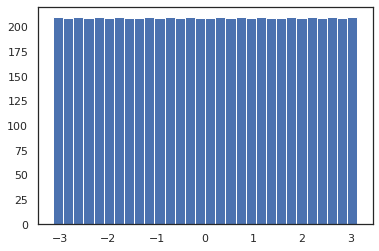

In [2]:
phi = np.arange(-np.pi,np.pi,0.001)
plt.hist(phi,bins=30)

Now let's pretend $\eta$ is some function of $\phi$:

(array([  4.,   6.,  26.,  80., 142., 196., 242., 295., 295., 274., 314.,
        274., 294., 290., 289., 284., 298., 278., 277., 304., 294., 272.,
        306., 278., 234., 185., 146.,  73.,  26.,   8.]),
 array([-4.3892989 , -4.10486277, -3.82042664, -3.53599051, -3.25155438,
        -2.96711825, -2.68268212, -2.39824599, -2.11380986, -1.82937373,
        -1.5449376 , -1.26050147, -0.97606534, -0.6916292 , -0.40719307,
        -0.12275694,  0.16167919,  0.44611532,  0.73055145,  1.01498758,
         1.29942371,  1.58385984,  1.86829597,  2.1527321 ,  2.43716823,
         2.72160436,  3.00604049,  3.29047662,  3.57491275,  3.85934888,
         4.14378501]),
 <a list of 30 Patch objects>)

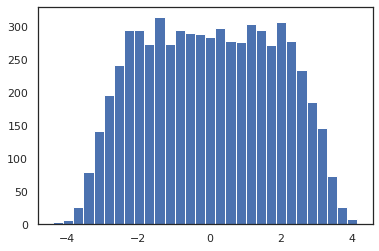

In [3]:
eta = phi + np.random.normal(-2,np.absolute(phi/10)) + np.random.normal(2,np.absolute(phi/10))
plt.hist(eta, bins=30)

And $p_T$ is some function of $\eta$

(array([396., 753., 654., 546., 409., 341., 306., 267., 232., 211., 191.,
        161., 144., 141., 159., 126., 116., 104., 107.,  98., 104., 100.,
         85.,  74.,  90.,  77.,  78.,  79.,  66.,  69.]),
 array([0.07445656, 0.27189312, 0.46932968, 0.66676624, 0.8642028 ,
        1.06163936, 1.25907592, 1.45651249, 1.65394905, 1.85138561,
        2.04882217, 2.24625873, 2.44369529, 2.64113185, 2.83856841,
        3.03600497, 3.23344153, 3.4308781 , 3.62831466, 3.82575122,
        4.02318778, 4.22062434, 4.4180609 , 4.61549746, 4.81293402,
        5.01037058, 5.20780714, 5.4052437 , 5.60268027, 5.80011683,
        5.99755339]),
 <a list of 30 Patch objects>)

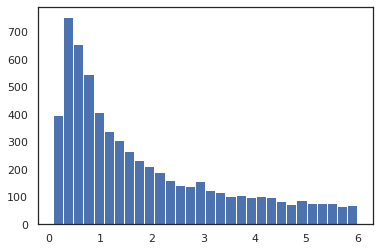

In [4]:
# Small |eta| = high pT
pt = np.exp(-np.absolute(eta))*6
plt.hist(pt, bins=30)


So far so good, let's chunk them together to create our toy dataset

In [9]:
phi = phi.reshape(-1,1)
eta = eta.reshape(-1,1)
pt = pt.reshape(-1,1)

idx = np.arange(len(phi))
np.random.shuffle(idx)
train_idx = idx[:int(len(phi)*0.8)]
val_idx = idx[int(len(phi)*0.8):]
dataset = np.concatenate((pt[train_idx],eta[train_idx],phi[train_idx]),1)
val_dataset = np.concatenate((pt[val_idx],eta[val_idx],phi[val_idx]),1)
print(dataset.shape)

class MyDataset(Dataset):
    def __init__(self, xdata, ydata):
        self.xdata = torch.from_numpy(xdata).float()
        self.ydata = torch.from_numpy(ydata).float()

    def __len__(self):
        return len(self.xdata)

    def __getitem__(self, idx):
        return self.xdata[idx], self.ydata[idx]
    
train_data = MyDataset(dataset, dataset)
train_loader = DataLoader(dataset=train_data, batch_size=1000, shuffle=True)
val_data = MyDataset(val_dataset, val_dataset)
val_loader = DataLoader(dataset=val_data, batch_size=1000, shuffle=True)


(5027, 3)


# Linear Model, MSE

In [220]:

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
        
model = MyModel()
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

for t in range(1000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = criterion(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))



Epoch 0: Loss: 5.060623645782471.
Epoch 50: Loss: 3.2655179500579834.
Epoch 100: Loss: 1.7948344945907593.
Epoch 150: Loss: 1.4323424100875854.
Epoch 200: Loss: 1.307456135749817.
Epoch 250: Loss: 1.1484861373901367.
Epoch 300: Loss: 1.1148359775543213.
Epoch 350: Loss: 1.0676095485687256.
Epoch 400: Loss: 0.8841525912284851.
Epoch 450: Loss: 0.9246156215667725.
Epoch 500: Loss: 0.8216058611869812.
Epoch 550: Loss: 0.9319902062416077.
Epoch 600: Loss: 0.8447998762130737.
Epoch 650: Loss: 0.8841612935066223.
Epoch 700: Loss: 0.7233100533485413.
Epoch 750: Loss: 0.8247567415237427.
Epoch 800: Loss: 0.7503125071525574.
Epoch 850: Loss: 0.691878080368042.
Epoch 900: Loss: 0.77344810962677.
Epoch 950: Loss: 0.7485801577568054.


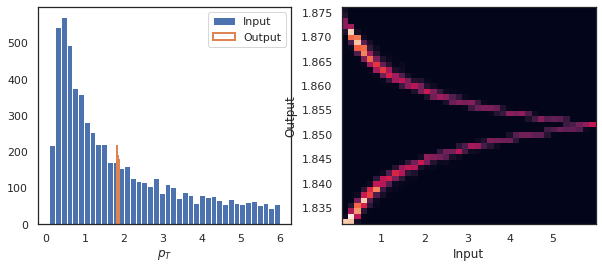

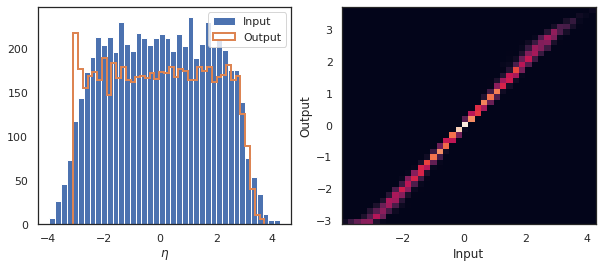

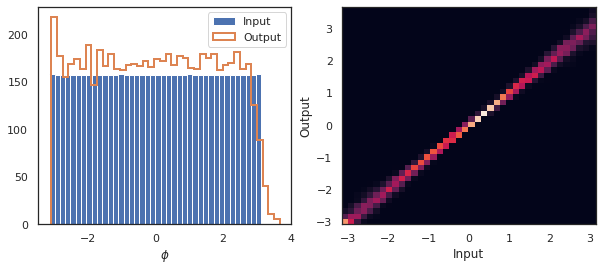

In [221]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

# Linear Model MSE -- After rerunning N times

Epoch 0: Loss: 3.581855535507202.
Epoch 50: Loss: 3.5177838802337646.
Epoch 100: Loss: 3.100940227508545.
Epoch 150: Loss: 3.070528507232666.
Epoch 200: Loss: 3.317605495452881.
Epoch 250: Loss: 2.9152097702026367.
Epoch 300: Loss: 3.0039453506469727.
Epoch 350: Loss: 2.6602718830108643.
Epoch 400: Loss: 3.077491283416748.
Epoch 450: Loss: 3.185708522796631.
Epoch 500: Loss: 2.983238935470581.
Epoch 550: Loss: 3.121546506881714.
Epoch 600: Loss: 3.1615185737609863.
Epoch 650: Loss: 2.9950151443481445.
Epoch 700: Loss: 3.1594629287719727.
Epoch 750: Loss: 3.09879207611084.
Epoch 800: Loss: 2.904749631881714.
Epoch 850: Loss: 2.9883220195770264.
Epoch 900: Loss: 2.884272813796997.
Epoch 950: Loss: 2.967571258544922.


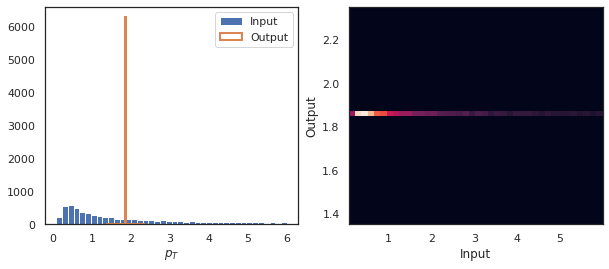

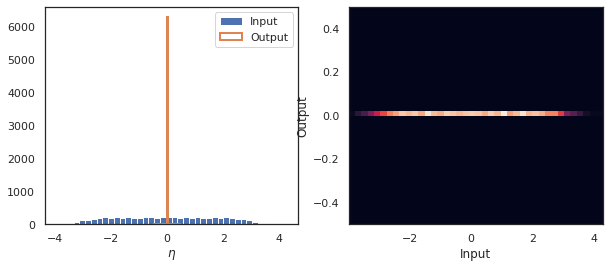

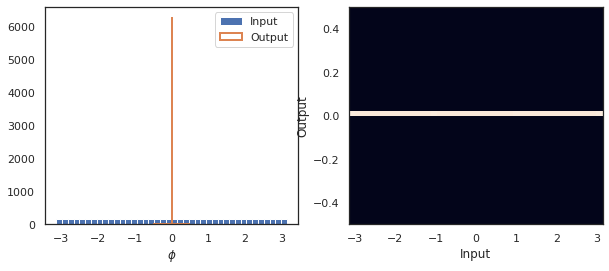

In [222]:

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
        
model = MyModel()
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

for t in range(1000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = criterion(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))

output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

# Linear Model MSE -- After rerunning N times

In [240]:

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
        
model = MyModel()
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

   
train_data = MyDataset(dataset, dataset)
train_loader = DataLoader(dataset=train_data, batch_size=1000, shuffle=True)

for t in range(2000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = criterion(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))


Epoch 0: Loss: 4.9568610191345215.
Epoch 50: Loss: 2.3459949493408203.
Epoch 100: Loss: 1.60237455368042.
Epoch 150: Loss: 1.363577127456665.
Epoch 200: Loss: 1.1176255941390991.
Epoch 250: Loss: 0.6715921759605408.
Epoch 300: Loss: 0.2594994604587555.
Epoch 350: Loss: 0.17601944506168365.
Epoch 400: Loss: 0.13328339159488678.
Epoch 450: Loss: 0.1224108338356018.
Epoch 500: Loss: 0.10927087068557739.
Epoch 550: Loss: 0.06698247045278549.
Epoch 600: Loss: 0.06329819560050964.
Epoch 650: Loss: 0.028155731037259102.
Epoch 700: Loss: 0.020587828010320663.
Epoch 750: Loss: 0.012626340612769127.
Epoch 800: Loss: 0.012954282574355602.
Epoch 850: Loss: 0.011203535832464695.
Epoch 900: Loss: 0.01088565494865179.
Epoch 950: Loss: 0.011917817406356335.
Epoch 1000: Loss: 0.011621775105595589.
Epoch 1050: Loss: 0.013143855147063732.
Epoch 1100: Loss: 0.011677134782075882.
Epoch 1150: Loss: 0.01141366083174944.
Epoch 1200: Loss: 0.009671580046415329.
Epoch 1250: Loss: 0.010496504604816437.
Epoch 130

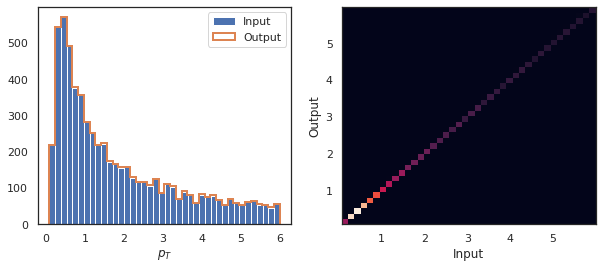

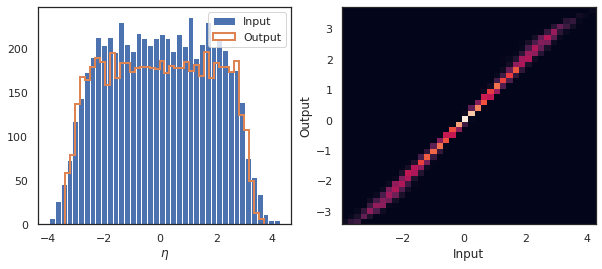

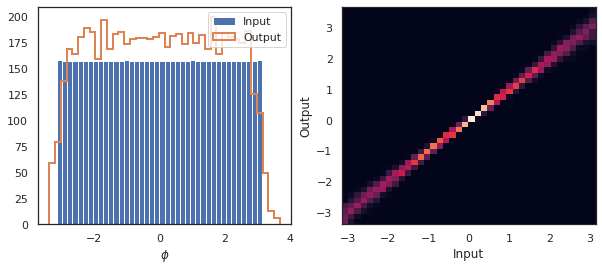

In [254]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(0,6)
plt.ylim(0,6)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')

plt.show()

This is successful, but after rerunning like 20 times.

# Linear Model MSE using SGD and optimal LR

In [44]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
        
model = MyModel()
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.e-1) # optimal LR obtained from LR finder below

   
train_data = MyDataset(dataset, dataset)
train_loader = DataLoader(dataset=train_data, batch_size=1000, shuffle=True)

for t in range(1000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = criterion(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))


Epoch 0: Loss: 3.3494937419891357.
Epoch 50: Loss: 0.7436863780021667.
Epoch 100: Loss: 0.33033230900764465.
Epoch 150: Loss: 0.0937718003988266.
Epoch 200: Loss: 0.20264247059822083.
Epoch 250: Loss: 0.12714901566505432.
Epoch 300: Loss: 0.13859671354293823.
Epoch 350: Loss: 0.12260140478610992.
Epoch 400: Loss: 0.11964821815490723.
Epoch 450: Loss: 0.1250724047422409.
Epoch 500: Loss: 0.07288738340139389.
Epoch 550: Loss: 0.08256921917200089.
Epoch 600: Loss: 0.1136634424328804.
Epoch 650: Loss: 0.13089783489704132.
Epoch 700: Loss: 0.0970800518989563.
Epoch 750: Loss: 0.12053538858890533.
Epoch 800: Loss: 0.14302095770835876.
Epoch 850: Loss: 0.09749257564544678.
Epoch 900: Loss: 0.11941619962453842.
Epoch 950: Loss: 0.09768913686275482.


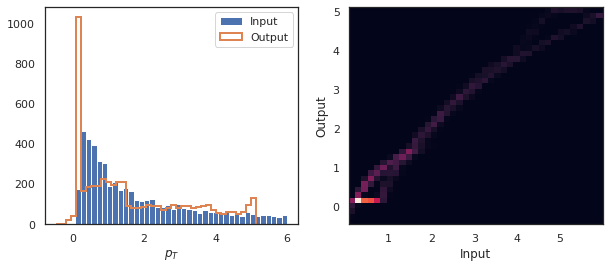

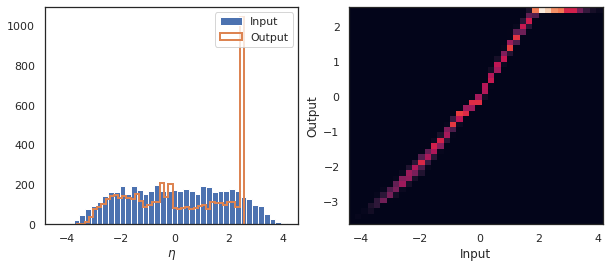

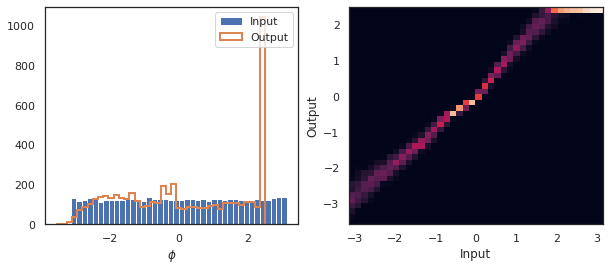

In [45]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(0,6)
plt.ylim(0,6)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')

plt.show()

# Linear Model MSE using SGD after N runs with optimal LR

In [59]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
        
model = MyModel()
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.e-1)

   
train_data = MyDataset(dataset, dataset)
train_loader = DataLoader(dataset=train_data, batch_size=1000, shuffle=True)

for t in range(1000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = criterion(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    for xval, yval in val_loader:
        y_pred = model(xval.float().cuda())
        label = yval.float().cuda()
        val_loss = criterion(label, y_pred)
        
    if t%50 == 0: print("Epoch {}: Loss: {:.3f}. Val Loss: {:.3f}".format(t, loss.item(), val_loss.item()))


Epoch 0: Loss: 4.268. Val Loss: 3.321
Epoch 50: Loss: 1.055. Val Loss: 1.025
Epoch 100: Loss: 0.325. Val Loss: 0.307
Epoch 150: Loss: 0.287. Val Loss: 0.232
Epoch 200: Loss: 0.235. Val Loss: 0.397
Epoch 250: Loss: 0.550. Val Loss: 0.347
Epoch 300: Loss: 0.321. Val Loss: 0.426
Epoch 350: Loss: 0.239. Val Loss: 0.415
Epoch 400: Loss: 0.150. Val Loss: 0.207
Epoch 450: Loss: 0.221. Val Loss: 0.337
Epoch 500: Loss: 0.202. Val Loss: 0.295
Epoch 550: Loss: 0.164. Val Loss: 0.192
Epoch 600: Loss: 0.210. Val Loss: 0.267
Epoch 650: Loss: 0.472. Val Loss: 0.409
Epoch 700: Loss: 0.266. Val Loss: 0.529
Epoch 750: Loss: 0.311. Val Loss: 0.535
Epoch 800: Loss: 0.249. Val Loss: 0.160
Epoch 850: Loss: 0.286. Val Loss: 0.415
Epoch 900: Loss: 0.456. Val Loss: 0.367
Epoch 950: Loss: 0.218. Val Loss: 0.261


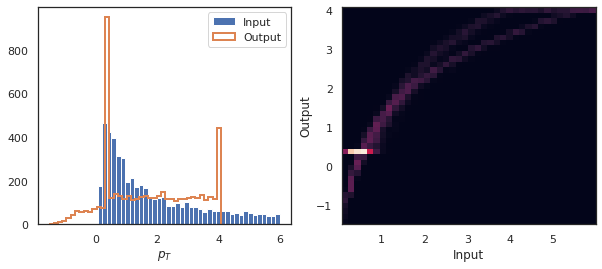

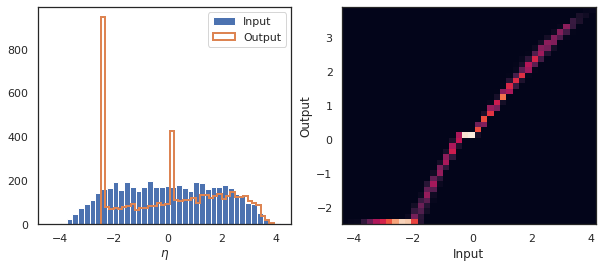

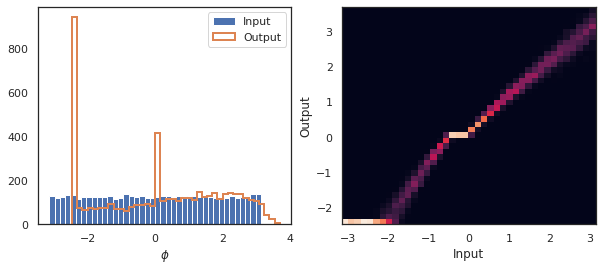

In [60]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(0,6)
plt.ylim(0,6)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')

plt.show()

# Linear Model MSE using Adam after N runs with optimal LR

In [50]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
        
model = MyModel()
model = model.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-1)

   
train_data = MyDataset(dataset, dataset)
train_loader = DataLoader(dataset=train_data, batch_size=1000, shuffle=True)

for t in range(1000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = criterion(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))


Epoch 0: Loss: 3.4984798431396484.
Epoch 50: Loss: 0.99308842420578.
Epoch 100: Loss: 0.797297477722168.
Epoch 150: Loss: 0.9379823803901672.
Epoch 200: Loss: 0.9200645089149475.
Epoch 250: Loss: 0.8929253816604614.
Epoch 300: Loss: 0.6305762529373169.
Epoch 350: Loss: 0.48532405495643616.
Epoch 400: Loss: 0.6258739829063416.
Epoch 450: Loss: 0.40575408935546875.
Epoch 500: Loss: 0.7807075381278992.
Epoch 550: Loss: 0.8831182718276978.
Epoch 600: Loss: 1.0034245252609253.
Epoch 650: Loss: 0.5710501074790955.
Epoch 700: Loss: 0.9407454133033752.
Epoch 750: Loss: 0.9922191500663757.
Epoch 800: Loss: 0.8092607855796814.
Epoch 850: Loss: 0.8506168127059937.
Epoch 900: Loss: 0.9463633894920349.
Epoch 950: Loss: 0.9936140179634094.


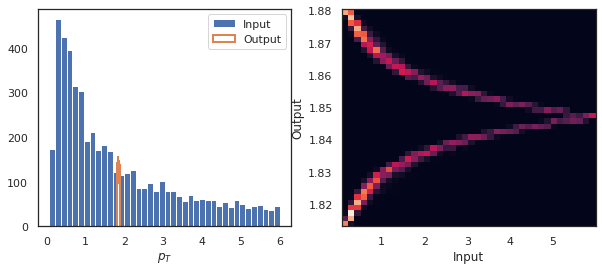

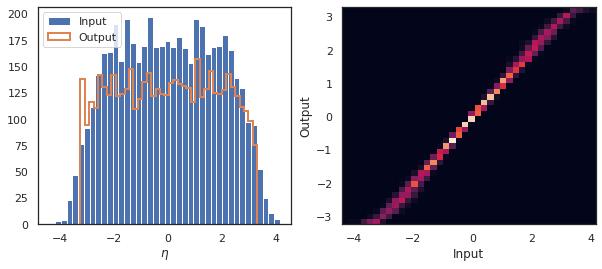

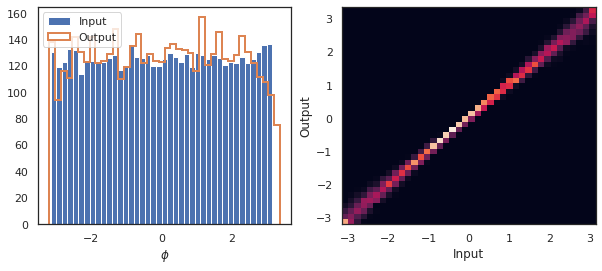

In [52]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(0,6)
plt.ylim(0,6)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-3.2,3.2)
plt.ylim(-3.2,3.2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')

plt.show()

Takeaway message: 
- Even a small AE is highly unstable and it's easy to get trapped into local minima. 
    - Can we escape this with 1-cycle training policy?


# One-cycle Learning Rate 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-01
Min loss divided by 10: 3.31E-01


epoch,train_loss,valid_loss,time
0,3.673344,3.606424,00:00
1,3.640007,3.534351,00:00
2,3.582369,3.466673,00:00
3,3.545096,3.403654,00:00
4,3.507866,3.345359,00:00
5,3.480019,3.291827,00:00
6,3.455439,3.243162,00:00
7,3.426335,3.199142,00:00
8,3.391507,3.159470,00:00
9,3.346661,3.124731,00:00


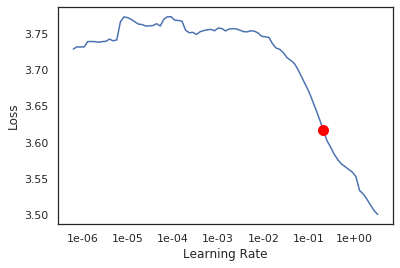

In [31]:
databunch = DataBunch(train_dl = train_loader, valid_dl = val_loader)

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        
        self.decoder = nn.Linear(2,3)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)        
        return self.decoder(encoded)
model = MyModel()
criterion = nn.MSELoss()
learn = Learner(data = databunch, model = model, loss_func=criterion)
learn.lr_find(start_lr=1e-7, end_lr=10., num_it=100, stop_div=False)
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(500, min_grad_lr)

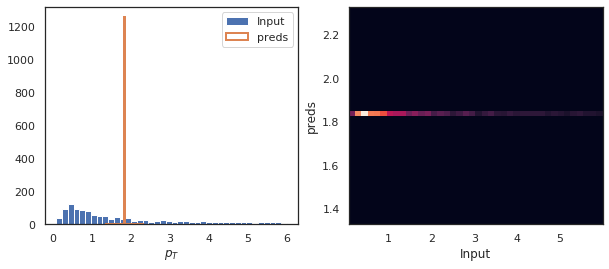

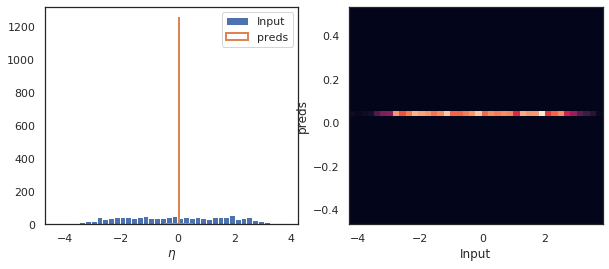

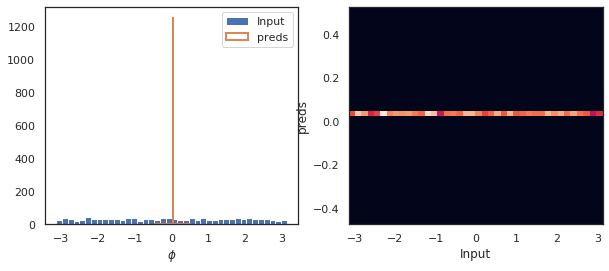

In [32]:
preds, y, losses = learn.get_preds(with_loss=True)
preds = preds.numpy()
y = y.numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y[:,0].flatten(),bins=40, label='Input')
plt.hist(preds[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='preds')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(y[:,0].flatten(),preds[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('preds')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y[:,1].flatten(),bins=40, label='Input')
plt.hist(preds[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='preds')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(y[:,1].flatten(),preds[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('preds')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y[:,2].flatten(),bins=40, label='Input')
plt.hist(preds[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='preds')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(y[:,2].flatten(),preds[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('preds')
plt.show()

So, no. One-cycle learning rate won't help stabilize autoencoders.

# Linear Model, Custom Loss mimicking MSE

In [38]:
def custom_loss(y_true, y_pred):
#     pt_loss = torch.pow(y_true[:,0].view(-1,1)-y_pred[:,0].view(-1,1),2)
#     eta_loss = torch.pow(y_true[:,1].view(-1,1)-y_pred[:,1].view(-1,1),2)
#     phi_loss = torch.pow(y_true[:,2].view(-1,1)-y_pred[:,2].view(-1,1),2)
    
#     return torch.sum(torch.sum((pt_loss+eta_loss+phi_loss), -1))
    return torch.mean(torch.sum(torch.pow(y_true-y_pred,2)))

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        self.decode_pt = nn.Linear(2,1)
        self.decode_eta = nn.Linear(2,1)
        self.decode_phi = nn.Linear(2,1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)
        pt = self.decode_pt(encoded)
        eta = self.decode_eta(encoded)
        phi = self.decode_phi(encoded)
        output = torch.cat((pt,eta,phi),1)
        return output
        
model = MyModel()
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

for t in range(500):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = custom_loss(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%20 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))





Epoch 0: Loss: 353.3349609375.
Epoch 20: Loss: 325.7461853027344.
Epoch 40: Loss: 200.04539489746094.
Epoch 60: Loss: 156.08367919921875.
Epoch 80: Loss: 135.08837890625.
Epoch 100: Loss: 80.73844909667969.
Epoch 120: Loss: 123.96481323242188.
Epoch 140: Loss: 84.89631652832031.
Epoch 160: Loss: 69.57121276855469.
Epoch 180: Loss: 66.72921752929688.
Epoch 200: Loss: 92.442138671875.
Epoch 220: Loss: 92.7352294921875.
Epoch 240: Loss: 127.88446044921875.
Epoch 260: Loss: 119.210693359375.
Epoch 280: Loss: 113.89862060546875.
Epoch 300: Loss: 69.21947479248047.
Epoch 320: Loss: 64.92195892333984.
Epoch 340: Loss: 64.81111145019531.
Epoch 360: Loss: 70.21194458007812.
Epoch 380: Loss: 81.87278747558594.
Epoch 400: Loss: 49.8734016418457.
Epoch 420: Loss: 68.56852722167969.
Epoch 440: Loss: 86.45555114746094.
Epoch 460: Loss: 61.153236389160156.
Epoch 480: Loss: 68.97566223144531.
Epoch 500: Loss: 71.36404418945312.
Epoch 520: Loss: 95.36393737792969.
Epoch 540: Loss: 45.31890869140625.
Ep

KeyboardInterrupt: 

In [ ]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

# Linear model, breaking down the loss and sum them over

In [179]:
def custom_loss(y_true, y_pred):
    pt_loss = torch.pow(y_true[:,0].view(-1,1)-y_pred[:,0].view(-1,1),2)
    eta_loss = torch.pow(y_true[:,1].view(-1,1)-y_pred[:,1].view(-1,1),2)
    phi_loss = torch.pow(y_true[:,2].view(-1,1)-y_pred[:,2].view(-1,1),2)
    
    return torch.mean(torch.sum((pt_loss+eta_loss+phi_loss), -1))
    
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        self.decode_pt = nn.Linear(2,1)
        self.decode_eta = nn.Linear(2,1)
        self.decode_phi = nn.Linear(2,1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)
        pt = self.decode_pt(encoded)
        eta = self.decode_eta(encoded)
        phi = self.decode_phi(encoded)
        output = torch.cat((pt,eta,phi),1)
        return output
        
model = MyModel()
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)
    
for t in range(5000):
    batch_loss = []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = custom_loss(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%50 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))





Epoch 0: Loss: 9.294410705566406.
Epoch 50: Loss: 6.485952377319336.
Epoch 100: Loss: 5.101860523223877.
Epoch 150: Loss: 3.6835362911224365.
Epoch 200: Loss: 1.6319019794464111.
Epoch 250: Loss: 1.700035572052002.
Epoch 300: Loss: 1.5214756727218628.
Epoch 350: Loss: 1.3379716873168945.
Epoch 400: Loss: 0.8186367750167847.
Epoch 450: Loss: 0.6725563406944275.
Epoch 500: Loss: 0.5237557888031006.
Epoch 550: Loss: 0.8654413223266602.
Epoch 600: Loss: 0.7130107283592224.
Epoch 650: Loss: 0.7023151516914368.
Epoch 700: Loss: 0.7232659459114075.
Epoch 750: Loss: 0.6699284315109253.
Epoch 800: Loss: 0.5922860503196716.
Epoch 850: Loss: 0.6718751192092896.
Epoch 900: Loss: 0.6852202415466309.
Epoch 950: Loss: 0.5727537274360657.
Epoch 1000: Loss: 0.9120477437973022.
Epoch 1050: Loss: 0.6892915368080139.
Epoch 1100: Loss: 0.6965158581733704.
Epoch 1150: Loss: 0.8055745959281921.
Epoch 1200: Loss: 0.6827384233474731.
Epoch 1250: Loss: 0.630942165851593.
Epoch 1300: Loss: 0.5720304250717163.
Ep

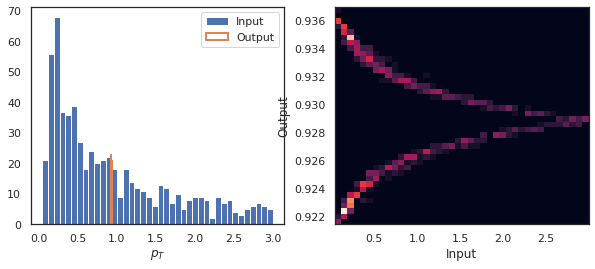

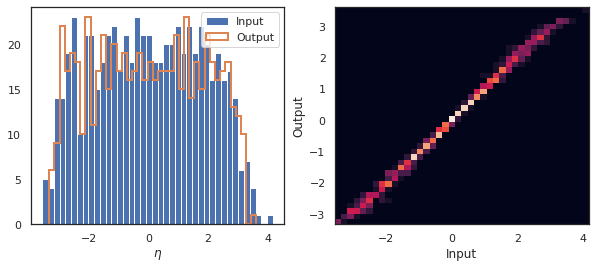

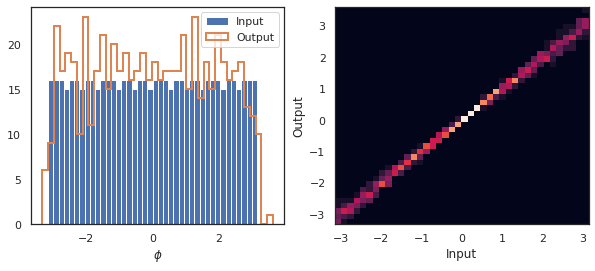

In [181]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

Now let's try with a custom loss, where $\phi$ loss is periodic and $\phi$ is bounded by ($-\pi, \pi$).

# Hardtanh $\phi$ bounded by $(-\pi, \pi)$, Periodic Loss

Now let's try with a custom loss, where $\phi$ loss is periodic and $\phi$ is bounded by ($-\pi, \pi$).

In [143]:
def custom_loss(y_true, y_pred):
    pt_loss = torch.pow(y_true[:,0]-y_pred[:,0],2)
    eta_loss = torch.pow(y_true[:,1]-y_pred[:,1],2)
    def phi_mpi_pi(x):
        return (x < -np.pi).float() * (x + 2*np.pi) + (x >= np.pi).float() * (x - 2*np.pi)
    phi_loss = torch.pow(phi_mpi_pi(y_true[:,2]-y_pred[:,2]),2)
    
    return torch.sum(pt_loss+eta_loss+phi_loss)
    

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        self.decode_pt = nn.Linear(2,1)
        self.decode_eta = nn.Linear(2,1)
        self.decode_phi = nn.Linear(2,1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)
        pt = self.decode_pt(encoded)
        eta = self.decode_eta(encoded)
        phi = F.hardtanh(self.decode_phi(encoded), min_val = -np.pi, max_val = np.pi)
        output = torch.cat((pt,eta,phi),1)
        return output
        
model = MyModel()
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)
    
for t in range(20000):
    batch_loss =  []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = custom_loss(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%20 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))




Epoch 0: Loss: 184.47496032714844.
Epoch 20: Loss: 166.7797088623047.
Epoch 40: Loss: 172.47280883789062.
Epoch 60: Loss: 121.8440170288086.
Epoch 80: Loss: 109.07723999023438.
Epoch 100: Loss: 99.27197265625.
Epoch 120: Loss: 106.33268737792969.
Epoch 140: Loss: 54.60984802246094.
Epoch 160: Loss: 58.88981628417969.
Epoch 180: Loss: 76.47368621826172.
Epoch 200: Loss: 83.9212646484375.
Epoch 220: Loss: 72.35038757324219.
Epoch 240: Loss: 82.6785659790039.
Epoch 260: Loss: 47.79118347167969.
Epoch 280: Loss: 67.06804656982422.
Epoch 300: Loss: 54.40315246582031.
Epoch 320: Loss: 101.40535736083984.
Epoch 340: Loss: 78.59223937988281.
Epoch 360: Loss: 73.86723327636719.
Epoch 380: Loss: 66.65597534179688.
Epoch 400: Loss: 87.01222229003906.
Epoch 420: Loss: 37.19527816772461.
Epoch 440: Loss: 62.22040557861328.
Epoch 460: Loss: 89.3752670288086.
Epoch 480: Loss: 58.009151458740234.
Epoch 500: Loss: 62.54609298706055.
Epoch 520: Loss: 52.5660285949707.
Epoch 540: Loss: 81.81745910644531.

Epoch 4480: Loss: 89.87838745117188.
Epoch 4500: Loss: 51.5150260925293.
Epoch 4520: Loss: 62.91106414794922.
Epoch 4540: Loss: 47.248130798339844.
Epoch 4560: Loss: 64.08670043945312.
Epoch 4580: Loss: 88.60858917236328.
Epoch 4600: Loss: 68.99854278564453.
Epoch 4620: Loss: 30.86117172241211.
Epoch 4640: Loss: 85.2034912109375.
Epoch 4660: Loss: 76.42086029052734.
Epoch 4680: Loss: 67.77301788330078.
Epoch 4700: Loss: 80.97096252441406.
Epoch 4720: Loss: 47.107574462890625.
Epoch 4740: Loss: 44.818702697753906.
Epoch 4760: Loss: 54.85515594482422.
Epoch 4780: Loss: 96.0179443359375.
Epoch 4800: Loss: 56.273887634277344.
Epoch 4820: Loss: 45.502593994140625.
Epoch 4840: Loss: 56.70735168457031.
Epoch 4860: Loss: 42.404335021972656.
Epoch 4880: Loss: 52.49652099609375.
Epoch 4900: Loss: 70.77108764648438.
Epoch 4920: Loss: 82.52992248535156.
Epoch 4940: Loss: 50.25909423828125.
Epoch 4960: Loss: 86.9969482421875.
Epoch 4980: Loss: 54.77846908569336.
Epoch 5000: Loss: 39.08592224121094.

Epoch 8920: Loss: 55.33746337890625.
Epoch 8940: Loss: 73.19718933105469.
Epoch 8960: Loss: 61.052574157714844.
Epoch 8980: Loss: 67.98243713378906.
Epoch 9000: Loss: 64.73361206054688.
Epoch 9020: Loss: 57.521400451660156.
Epoch 9040: Loss: 77.43378448486328.
Epoch 9060: Loss: 72.1949462890625.
Epoch 9080: Loss: 59.76209259033203.
Epoch 9100: Loss: 55.5384521484375.
Epoch 9120: Loss: 36.52499771118164.
Epoch 9140: Loss: 48.90229797363281.
Epoch 9160: Loss: 49.29761505126953.
Epoch 9180: Loss: 67.91806030273438.
Epoch 9200: Loss: 61.152854919433594.
Epoch 9220: Loss: 64.30116271972656.
Epoch 9240: Loss: 59.97814178466797.
Epoch 9260: Loss: 68.85295867919922.
Epoch 9280: Loss: 74.06333923339844.
Epoch 9300: Loss: 67.74708557128906.
Epoch 9320: Loss: 43.70793914794922.
Epoch 9340: Loss: 55.79882049560547.
Epoch 9360: Loss: 75.74832916259766.
Epoch 9380: Loss: 53.55738067626953.
Epoch 9400: Loss: 54.97856903076172.
Epoch 9420: Loss: 46.34441375732422.
Epoch 9440: Loss: 64.71759796142578.


Epoch 13280: Loss: 77.33433532714844.
Epoch 13300: Loss: 68.07787322998047.
Epoch 13320: Loss: 76.43980407714844.
Epoch 13340: Loss: 63.66963195800781.
Epoch 13360: Loss: 48.96075439453125.
Epoch 13380: Loss: 66.18278503417969.
Epoch 13400: Loss: 73.25505065917969.
Epoch 13420: Loss: 54.2747802734375.
Epoch 13440: Loss: 50.48361587524414.
Epoch 13460: Loss: 70.7599868774414.
Epoch 13480: Loss: 55.07396697998047.
Epoch 13500: Loss: 87.47659301757812.
Epoch 13520: Loss: 60.657630920410156.
Epoch 13540: Loss: 36.128265380859375.
Epoch 13560: Loss: 29.829450607299805.
Epoch 13580: Loss: 46.69085693359375.
Epoch 13600: Loss: 48.8009033203125.
Epoch 13620: Loss: 110.476806640625.
Epoch 13640: Loss: 48.579071044921875.
Epoch 13660: Loss: 86.43177795410156.
Epoch 13680: Loss: 70.03491973876953.
Epoch 13700: Loss: 29.334226608276367.
Epoch 13720: Loss: 57.30192565917969.
Epoch 13740: Loss: 92.39156341552734.
Epoch 13760: Loss: 81.57499694824219.
Epoch 13780: Loss: 45.43323516845703.
Epoch 13800

Epoch 17600: Loss: 51.87715148925781.
Epoch 17620: Loss: 55.025733947753906.
Epoch 17640: Loss: 67.86967468261719.
Epoch 17660: Loss: 39.79193878173828.
Epoch 17680: Loss: 105.41018676757812.
Epoch 17700: Loss: 67.10594940185547.
Epoch 17720: Loss: 68.06454467773438.
Epoch 17740: Loss: 78.90454864501953.
Epoch 17760: Loss: 67.29718017578125.
Epoch 17780: Loss: 46.53804397583008.
Epoch 17800: Loss: 68.17929077148438.
Epoch 17820: Loss: 47.42906951904297.
Epoch 17840: Loss: 49.000770568847656.
Epoch 17860: Loss: 43.48522186279297.
Epoch 17880: Loss: 47.18988037109375.
Epoch 17900: Loss: 54.792274475097656.
Epoch 17920: Loss: 76.23573303222656.
Epoch 17940: Loss: 58.69927978515625.
Epoch 17960: Loss: 99.86878967285156.
Epoch 17980: Loss: 78.67444610595703.
Epoch 18000: Loss: 74.7353286743164.
Epoch 18020: Loss: 64.36753845214844.
Epoch 18040: Loss: 79.12844848632812.
Epoch 18060: Loss: 38.168113708496094.
Epoch 18080: Loss: 75.4390869140625.
Epoch 18100: Loss: 68.99163818359375.
Epoch 181

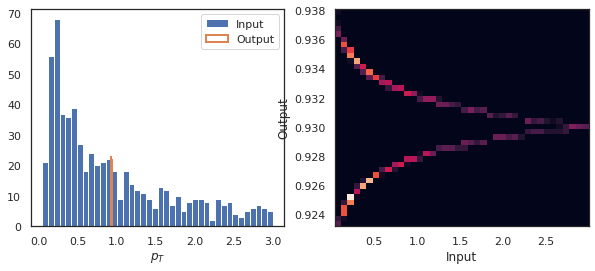

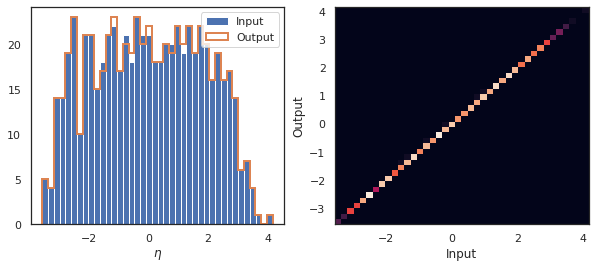

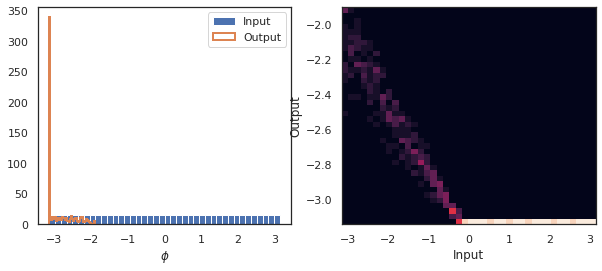

In [144]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

Clearly doesn't work. How about we try with $\pi \sin(x)$?

# $\phi$ activated with $\pi\sin(x)$. MSE

In [145]:
def custom_loss(y_true, y_pred):
    pt_loss = torch.pow(y_true[:,0]-y_pred[:,0],2)
    eta_loss = torch.pow(y_true[:,1]-y_pred[:,1],2)
    phi_loss = torch.pow(y_true[:,2]-y_pred[:,2],2)
    
    return torch.sum(pt_loss+eta_loss+phi_loss)
    

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(3,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU(), 
                                     nn.Linear(2,2), nn.ReLU())
        self.decode_pt = nn.Linear(2,1)
        self.decode_eta = nn.Linear(2,1)
        self.decode_phi = nn.Linear(2,1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def forward(self, x):
        encoded = self.encoder(x)
        pt = self.decode_pt(encoded)
        eta = self.decode_eta(encoded)
        phi = np.pi*torch.sin(self.decode_phi(encoded))
        output = torch.cat((pt,eta,phi),1)
        return output
        
model = MyModel()
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

for t in range(20000):
    batch_loss =  []
    for xtrain, ytrain in train_loader:
        
        y_pred = model(xtrain.float().cuda())
        label = ytrain.float().cuda()
        
        # Compute and print loss.
        loss = custom_loss(label, y_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  
    if t%20 == 0: print("Epoch {}: Loss: {}.".format(t, loss.item()))




Epoch 0: Loss: 207.65438842773438.
Epoch 20: Loss: 215.00814819335938.
Epoch 40: Loss: 121.92072296142578.
Epoch 60: Loss: 63.894561767578125.
Epoch 80: Loss: 64.53491973876953.
Epoch 100: Loss: 40.71171188354492.
Epoch 120: Loss: 48.536224365234375.
Epoch 140: Loss: 24.751920700073242.
Epoch 160: Loss: 34.73759841918945.
Epoch 180: Loss: 33.91426086425781.
Epoch 200: Loss: 17.06058120727539.
Epoch 220: Loss: 20.29612922668457.
Epoch 240: Loss: 21.754302978515625.
Epoch 260: Loss: 22.32611083984375.
Epoch 280: Loss: 21.849992752075195.
Epoch 300: Loss: 27.035930633544922.
Epoch 320: Loss: 17.342012405395508.
Epoch 340: Loss: 13.475399017333984.
Epoch 360: Loss: 26.556835174560547.
Epoch 380: Loss: 19.18373680114746.
Epoch 400: Loss: 28.40620231628418.
Epoch 420: Loss: 22.915145874023438.
Epoch 440: Loss: 13.59018325805664.
Epoch 460: Loss: 21.164003372192383.
Epoch 480: Loss: 11.766714096069336.
Epoch 500: Loss: 14.035932540893555.
Epoch 520: Loss: 26.896602630615234.
Epoch 540: Loss: 

Epoch 4400: Loss: 14.147977828979492.
Epoch 4420: Loss: 15.743846893310547.
Epoch 4440: Loss: 27.628273010253906.
Epoch 4460: Loss: 21.900390625.
Epoch 4480: Loss: 20.906431198120117.
Epoch 4500: Loss: 16.150983810424805.
Epoch 4520: Loss: 14.560953140258789.
Epoch 4540: Loss: 16.52260398864746.
Epoch 4560: Loss: 17.032381057739258.
Epoch 4580: Loss: 19.138381958007812.
Epoch 4600: Loss: 18.449399948120117.
Epoch 4620: Loss: 22.71759796142578.
Epoch 4640: Loss: 28.49266242980957.
Epoch 4660: Loss: 15.500871658325195.
Epoch 4680: Loss: 20.79681396484375.
Epoch 4700: Loss: 16.204673767089844.
Epoch 4720: Loss: 17.045249938964844.
Epoch 4740: Loss: 15.385790824890137.
Epoch 4760: Loss: 20.299251556396484.
Epoch 4780: Loss: 13.589576721191406.
Epoch 4800: Loss: 25.64521026611328.
Epoch 4820: Loss: 20.61114501953125.
Epoch 4840: Loss: 14.706165313720703.
Epoch 4860: Loss: 14.982927322387695.
Epoch 4880: Loss: 15.856810569763184.
Epoch 4900: Loss: 14.973079681396484.
Epoch 4920: Loss: 17.814

Epoch 8760: Loss: 19.40306282043457.
Epoch 8780: Loss: 17.661996841430664.
Epoch 8800: Loss: 10.535472869873047.
Epoch 8820: Loss: 12.767470359802246.
Epoch 8840: Loss: 20.608863830566406.
Epoch 8860: Loss: 18.302127838134766.
Epoch 8880: Loss: 19.182165145874023.
Epoch 8900: Loss: 23.404808044433594.
Epoch 8920: Loss: 16.558345794677734.
Epoch 8940: Loss: 18.78809356689453.
Epoch 8960: Loss: 29.09786605834961.
Epoch 8980: Loss: 16.611724853515625.
Epoch 9000: Loss: 15.077483177185059.
Epoch 9020: Loss: 20.988536834716797.
Epoch 9040: Loss: 8.971268653869629.
Epoch 9060: Loss: 23.558345794677734.
Epoch 9080: Loss: 22.063987731933594.
Epoch 9100: Loss: 12.13175106048584.
Epoch 9120: Loss: 18.0855712890625.
Epoch 9140: Loss: 19.970539093017578.
Epoch 9160: Loss: 22.342323303222656.
Epoch 9180: Loss: 14.242646217346191.
Epoch 9200: Loss: 11.01473331451416.
Epoch 9220: Loss: 14.218364715576172.
Epoch 9240: Loss: 10.915718078613281.
Epoch 9260: Loss: 17.223657608032227.
Epoch 9280: Loss: 19

Epoch 13040: Loss: 13.292169570922852.
Epoch 13060: Loss: 15.237726211547852.
Epoch 13080: Loss: 17.43536376953125.
Epoch 13100: Loss: 19.932994842529297.
Epoch 13120: Loss: 17.587440490722656.
Epoch 13140: Loss: 12.92085075378418.
Epoch 13160: Loss: 16.744792938232422.
Epoch 13180: Loss: 29.003089904785156.
Epoch 13200: Loss: 17.684228897094727.
Epoch 13220: Loss: 13.035202026367188.
Epoch 13240: Loss: 21.374942779541016.
Epoch 13260: Loss: 16.164745330810547.
Epoch 13280: Loss: 21.350616455078125.
Epoch 13300: Loss: 16.780698776245117.
Epoch 13320: Loss: 21.003646850585938.
Epoch 13340: Loss: 17.8724365234375.
Epoch 13360: Loss: 20.37474250793457.
Epoch 13380: Loss: 15.41942310333252.
Epoch 13400: Loss: 10.07124137878418.
Epoch 13420: Loss: 19.58798599243164.
Epoch 13440: Loss: 18.775047302246094.
Epoch 13460: Loss: 18.213520050048828.
Epoch 13480: Loss: 18.87677764892578.
Epoch 13500: Loss: 18.44371223449707.
Epoch 13520: Loss: 17.540843963623047.
Epoch 13540: Loss: 12.2019462585449

Epoch 17280: Loss: 11.595454216003418.
Epoch 17300: Loss: 15.733109474182129.
Epoch 17320: Loss: 16.42055892944336.
Epoch 17340: Loss: 16.333953857421875.
Epoch 17360: Loss: 11.91547966003418.
Epoch 17380: Loss: 13.499818801879883.
Epoch 17400: Loss: 12.857250213623047.
Epoch 17420: Loss: 16.067466735839844.
Epoch 17440: Loss: 22.620769500732422.
Epoch 17460: Loss: 17.15227508544922.
Epoch 17480: Loss: 18.321590423583984.
Epoch 17500: Loss: 11.01080322265625.
Epoch 17520: Loss: 15.203857421875.
Epoch 17540: Loss: 16.720735549926758.
Epoch 17560: Loss: 26.780967712402344.
Epoch 17580: Loss: 23.70543670654297.
Epoch 17600: Loss: 17.991687774658203.
Epoch 17620: Loss: 16.45676040649414.
Epoch 17640: Loss: 11.12979507446289.
Epoch 17660: Loss: 18.607507705688477.
Epoch 17680: Loss: 17.038089752197266.
Epoch 17700: Loss: 23.686695098876953.
Epoch 17720: Loss: 16.35349464416504.
Epoch 17740: Loss: 12.440028190612793.
Epoch 17760: Loss: 15.762922286987305.
Epoch 17780: Loss: 13.69081687927246

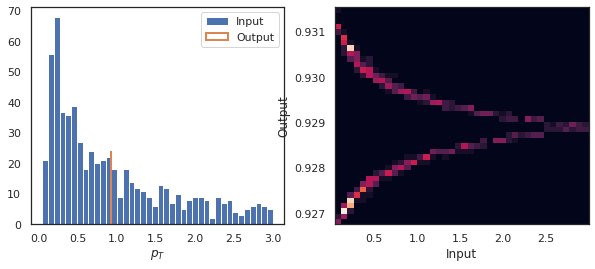

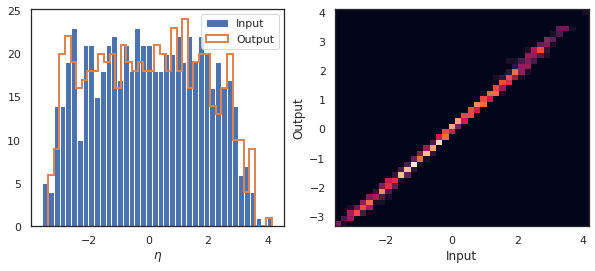

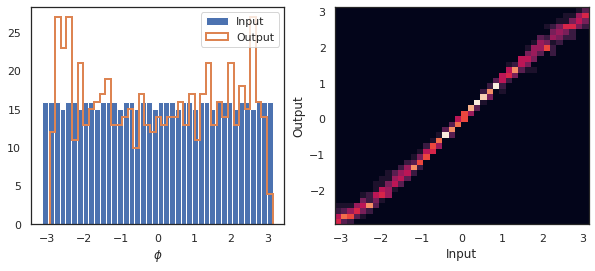

In [146]:
output = model.cpu()(torch.from_numpy(dataset).float())
output = output.cpu().data.numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,0].flatten(),bins=40, label='Input')
plt.hist(output[:,0].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$p_T$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,0].flatten(),output[:,0].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,1].flatten(),bins=40, label='Input')
plt.hist(output[:,1].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\eta$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,1].flatten(),output[:,1].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(dataset[:,2].flatten(),bins=40, label='Input')
plt.hist(output[:,2].flatten(),bins=40, histtype='step', linewidth=2, label='Output')
plt.xlabel('$\phi$')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.hist2d(dataset[:,2].flatten(),output[:,2].flatten(),bins=40)
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

# Takeaway messages

- Even a simple autoencoders is hard to train because of stability.
- Cyclical learning rate doesn't help.
- Adam/SGD doesn't help.
- Optimal learning rate doesn't help.
- Be patient a